## Dependencias 

In [54]:
import numpy as np 
import pandas as pd 


import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from sklearn.tree import DecisionTreeClassifier,plot_tree,export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score
#from scikitplot.metrics import plot_roc
from varclushi import VarClusHi

from CreditScoringToolkit.frequency_table import frequency_table

cf.go_offline()

## Cargar Datos

In [2]:
data = pd.read_sas('../data/churn.sas7bdat')
data.shape

(2801, 14)

In [3]:
data.head()

,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128.0,b'No',b'Yes',25.0,45.07,99.0,16.78,91.0,11.01,3.0,2.70,1.0,0.0,1.0
1,107.0,b'No',b'Yes',26.0,27.47,103.0,16.62,103.0,11.45,3.0,3.70,1.0,0.0,2.0
2,137.0,b'No',b'No',0.0,41.38,110.0,10.30,104.0,7.32,5.0,3.29,0.0,0.0,3.0
3,65.0,b'No',b'No',0.0,21.95,83.0,19.42,111.0,9.40,6.0,3.43,4.0,1.0,11.0
4,168.0,b'No',b'No',0.0,21.90,71.0,8.92,128.0,6.35,2.0,3.02,1.0,0.0,13.0


## Partición

In [4]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((1960, 14), (841, 14))

## Naturaleza de variables 

In [43]:
um = ['ID']
varc = [v for v in data.columns if v[:2]=='V_']
vard = [v for v in data.columns if v[:2]=='C_']
vart = ['TARGET']
len(varc),len(vard)

(10, 2)

## Análisis Exploratorio de Datos 

### Discreto

#### Frecuencia

In [50]:
frequency_table(train, vard)
frequency_table(train, vart)

****Frequency Table  TARGET  ***


        Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
TARGET                                                            
0.0           1594    0.866775              1594          0.866775
1.0            245    0.133225              1839          1.000000






### Continuo 

#### Ausentes 

In [7]:
train[varc].isna().sum()

V_ACCT_LGHT      0
V_N_VM_MESS      0
V_T_DAY_CHG      0
V_T_EVE_CALLS    0
V_T_EVE_CHG      0
V_T_NIG_CALLS    0
V_T_NIG_CHG      0
V_T_INT_CALLS    0
V_T_INT_CHG      0
V_CS_CALLS       0
dtype: int64

#### Multicolinealidad 

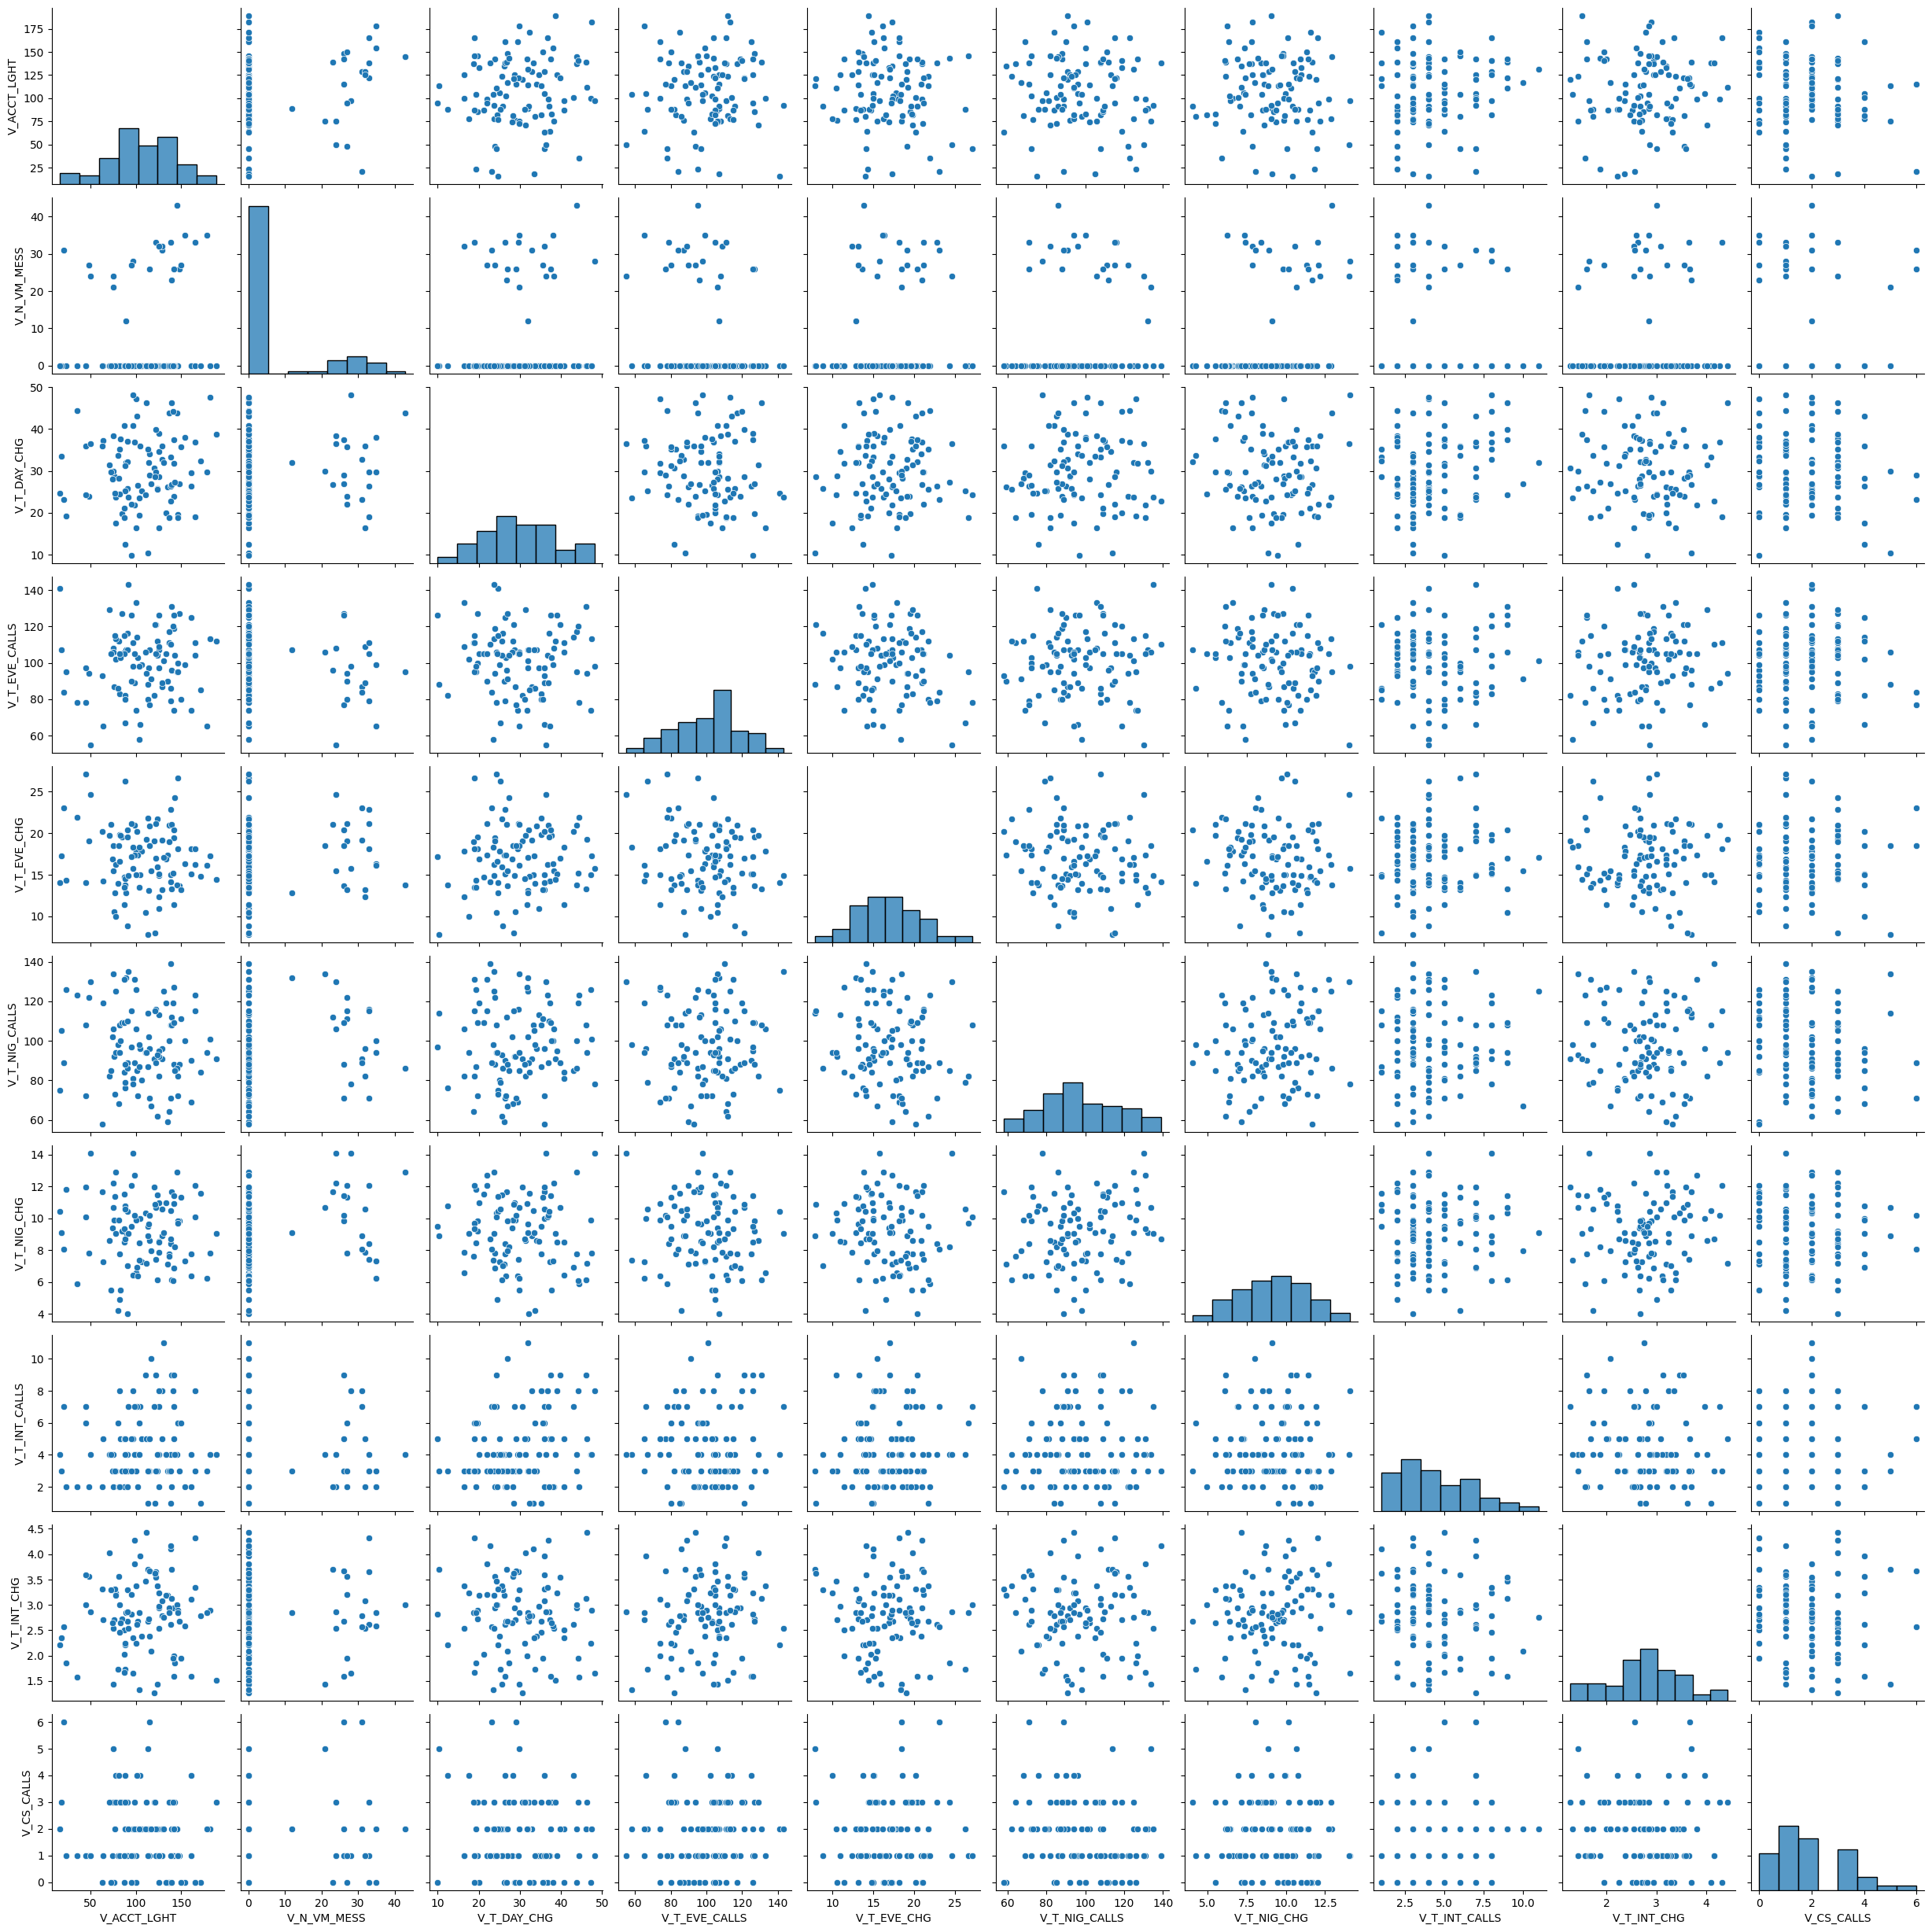

In [14]:
sns.pairplot(train[varc].sample(100))

In [11]:
vc = VarClusHi(df=train,feat_list=varc).varclus()

In [12]:
vc.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,V_N_VM_MESS,0.146135,0.000391,0.854199
1,0,V_T_DAY_CHG,0.391998,0.000248,0.608153
2,0,V_T_EVE_CHG,0.310623,0.000009,0.689383
3,0,V_T_INT_CALLS,0.210493,0.000418,0.789837
4,1,V_T_NIG_CALLS,0.214360,0.000735,0.786217
5,1,V_T_NIG_CHG,0.400396,0.001081,0.600252
6,1,V_CS_CALLS,0.456541,0.000976,0.543989
7,2,V_ACCT_LGHT,0.527801,0.001081,0.472710
8,2,V_T_EVE_CALLS,0.527801,0.000133,0.472261
9,3,V_T_INT_CHG,1.000000,0.000287,0.000000


In [15]:
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

In [16]:
mc

['V_T_DAY_CHG', 'V_CS_CALLS', 'V_T_EVE_CALLS', 'V_T_INT_CHG']

#### Distribución 

array([[<Axes: title={'center': 'V_T_DAY_CHG'}>,
        <Axes: title={'center': 'V_CS_CALLS'}>],
       [<Axes: title={'center': 'V_T_EVE_CALLS'}>,
        <Axes: title={'center': 'V_T_INT_CHG'}>]], dtype=object)

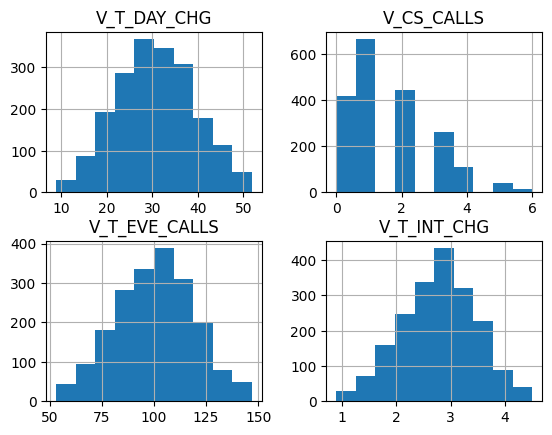

In [17]:
train[mc].hist()

#### Extremos 

In [27]:
for v,li,ls in train[mc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li) | (train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').max(axis=1) 
frequency_table(train, ['ex_'])

****Frequency Table  ex_  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
ex_                                                            
0          1839    0.938265              1839          0.938265
1           121    0.061735              1960          1.000000






In [28]:
train = train[train['ex_']==0].reset_index(drop=True)
train.drop(train.filter(like='ex_').columns,axis=1,inplace=True)

array([[<Axes: title={'center': 'V_T_DAY_CHG'}>,
        <Axes: title={'center': 'V_CS_CALLS'}>],
       [<Axes: title={'center': 'V_T_EVE_CALLS'}>,
        <Axes: title={'center': 'V_T_INT_CHG'}>]], dtype=object)

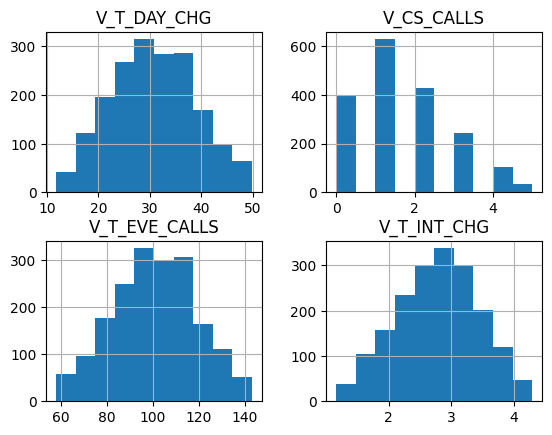

In [31]:
train[mc].hist()

## Pre-procesamiento

In [40]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False)
oh.fit(train[vard])
train[oh.get_feature_names_out()] = oh.transform(train[vard])

In [42]:
varoh = oh.get_feature_names_out().tolist()

In [45]:
train = train[um+vart+varoh+mc]
train.head()

,ID,TARGET,C_IP_b'Yes',C_VMP_b'Yes',V_T_DAY_CHG,V_CS_CALLS,V_T_EVE_CALLS,V_T_INT_CHG
0,912.0,1.0,0.0,0.0,45.53,5.0,121.0,3.89
1,1478.0,0.0,0.0,0.0,28.66,1.0,117.0,2.65
2,1795.0,1.0,0.0,0.0,48.72,1.0,108.0,3.11
3,2286.0,0.0,0.0,0.0,26.59,1.0,98.0,3.19
4,2265.0,0.0,0.0,0.0,33.49,3.0,107.0,2.35


## Aprendizaje 

In [46]:
dt = DecisionTreeClassifier()

In [47]:
dt.fit(train[varoh+mc],train[vart])

DecisionTreeClassifier()

[Text(0.741501975194209, 0.975, 'V_T_DAY_CHG <= 41.665\ngini = 0.231\nsamples = 1839\nvalue = [1594, 245]\nclass = 0'),
 Text(0.548681916490113, 0.925, 'V_CS_CALLS <= 3.5\ngini = 0.179\nsamples = 1659\nvalue = [1494, 165]\nclass = 0'),
 Text(0.645091945842161, 0.95, 'True  '),
 Text(0.4321095956920904, 0.875, "C_IP_b'Yes' <= 0.5\ngini = 0.128\nsamples = 1531\nvalue = [1426, 105]\nclass = 0"),
 Text(0.3048971574858757, 0.825, 'V_T_DAY_CHG <= 37.715\ngini = 0.081\nsamples = 1396\nvalue = [1337, 59]\nclass = 0'),
 Text(0.1957759533898305, 0.775, 'V_T_DAY_CHG <= 36.05\ngini = 0.055\nsamples = 1233\nvalue = [1198, 35]\nclass = 0'),
 Text(0.12884004237288135, 0.725, 'V_T_INT_CHG <= 4.175\ngini = 0.048\nsamples = 1126\nvalue = [1098, 28]\nclass = 0'),
 Text(0.052171610169491525, 0.675, 'V_T_DAY_CHG <= 19.235\ngini = 0.046\nsamples = 1112\nvalue = [1086, 26]\nclass = 0'),
 Text(0.01694915254237288, 0.625, 'V_T_DAY_CHG <= 19.22\ngini = 0.11\nsamples = 137\nvalue = [129, 8]\nclass = 0'),
 Text(0

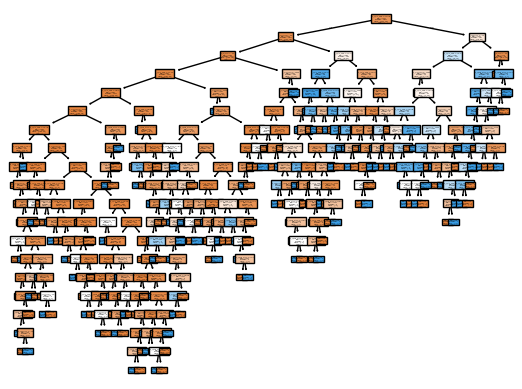

In [48]:
plot_tree(dt,feature_names=varoh+mc,class_names=['0','1'],filled=True)

## Validación del modelo

In [57]:
valid[oh.get_feature_names_out()] = oh.transform(valid[vard])

In [58]:
print("train",roc_auc_score(y_true=train[vart],
              y_score=dt.predict_proba(train[varoh+mc])[:,1]))
print("valid",roc_auc_score(y_true=valid[vart],
                y_score=dt.predict_proba(valid[varoh+mc])[:,1]))

train 1.0
valid 0.7520693512304252
